In [1]:
%matplotlib inline
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Materials definition

fuel = openmc.Material(name='Fuel Kernel') #tpcu
fuel.add_nuclide('U235', 0.155)
fuel.add_nuclide('U238', 0.845)
fuel.add_element('C', 0.5)
fuel.add_element('O', 1.5)
fuel.set_density('g/cm3', 10.5)
fuel.temperature = 1200


buffer = openmc.Material(name='Buffer Layer')
buffer.add_element('C', 1.0)
buffer.set_density('g/cm3', 1)
buffer.add_s_alpha_beta('c_Graphite')
buffer.temperature = 1200

IPyC = openmc.Material(name='Inner PyC Layer')
IPyC.add_element('C', 1.0)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')
IPyC.temperature = 1200

SiC = openmc.Material(name = "SiC Layer")
SiC.add_element("Si", 1)
SiC.add_element("C", 1)
SiC.set_density("g/cm3", 3.2)
SiC.temperature = 1200

OPyC = openmc.Material(name='Outer PyC Layer')
OPyC.add_element('C', 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite') 
OPyC.temperature = 1200

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.85)
graphite.add_s_alpha_beta('c_Graphite')
graphite.temperature = 800


helium = openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.0051)
helium.temperature = 900


b4c = openmc.Material(name='B4C Poison')
b4c.add_element('B', 4.0, enrichment=19.8, enrichment_target='B10', enrichment_type='wo')
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.52)
b4c.temperature = 1200










# Instantiate a Materials collection and export to xml
materials_list = [fuel, buffer, IPyC, SiC, OPyC, graphite, helium,
                  b4c]
materials_file = openmc.Materials(materials_list)
materials_file.export_to_xml()








In [3]:
# Geometry definitions for TRISO particles

kernelsph = openmc.Sphere(r=0.02125)
buffsph = openmc.Sphere(r=0.03125)
IPyCsph = openmc.Sphere(r=0.03475)
SiCsph = openmc.Sphere(r=0.03825)
OPyCsph = openmc.Sphere(r=0.04225)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, buffer, IPyC, SiC, OPyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
# triso_colors = {triso_cells[0]: (238,44,44), triso_cells[1]: (173,255,47), 
#                 triso_cells[2]: (32,178,170), triso_cells[3]: (75,0,130), 
#                 triso_cells[4]: (32,178,170)}
#triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)


In [4]:
# Generating TRISO particle lattice in cylindrical pin cell

cylsurf = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=(79.3/2), boundary_type='reflective')
minz = openmc.ZPlane(z0=-(79.3/2), boundary_type='reflective')

lattice_region = -cylsurf & -maxz & +minz
triso_outer_radius = 0.04225
spheres = openmc.model.pack_spheres(radius=triso_outer_radius, region=lattice_region, pf=0.30)



triso_particles = [openmc.model.TRISO(triso_outer_radius, fill=triso_universe, center=c) for c in spheres]


vol_triso = 4/3 * 3.14 * triso_outer_radius**3 * len(triso_particles)




lattice_cell = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
triso_latt = openmc.model.create_triso_lattice(triso_particles, lower_left, pitch, shape, graphite)
lattice_cell.fill = triso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell])


#lattice_universe.plot(width=(1.8, 1.8), color_by='material', colors = {graphite: (97, 97, 97),fuel: (238, 59, 59)})


In [5]:
# Creating coolant cells
small_coolant_surf = openmc.ZCylinder(r=0.635)
big_coolant_surf = openmc.ZCylinder(r=0.794)

small_coolant_cell = openmc.Cell(region=-small_coolant_surf & -maxz & +minz, fill=helium)
big_coolant_cell = openmc.Cell(region=-big_coolant_surf & -maxz & +minz, fill=helium)

outside_small_cell = openmc.Cell(region=+small_coolant_surf & -maxz & +minz, fill=graphite)
outside_big_cell = openmc.Cell(region=+big_coolant_surf & -maxz & +minz, fill=graphite)

scu = openmc.Universe(cells=[small_coolant_cell, outside_small_cell]) # scu means small coolant universe
bcu = openmc.Universe(cells=[big_coolant_cell, outside_big_cell])     # bcu means big coolant universe



In [6]:
poison_surf = openmc.ZCylinder(r=0.5715)
poison_cell = openmc.Cell(region=-poison_surf & -maxz & +minz, fill=b4c)
outside_poison_cell = openmc.Cell(region=+poison_surf & -maxz & +minz, fill=graphite)

pu = openmc.Universe(cells=[poison_cell, outside_poison_cell]) # pu means poison universe


In [7]:
outer_pin_region = +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region=outer_pin_region)

tpcu = openmc.Universe(cells=[lattice_cell, outer_pin_cell]) # tpcu means total pin cell universe



In [8]:
outer_graphite_cell = openmc.Cell(fill=graphite)
ogu = openmc.Universe(cells=[outer_graphite_cell]) # ogu means outer graphite universe


In [9]:
# Construct geometry of the hexagonal fuel assembly
# ogu, tpcu, pu, scu, bcu
# outer_graphite_universe, total_pin_cell_universe, poison_universe, small_coolant_universe, big_coolant_universe

assemblylat = openmc.HexLattice(name="Assembly")
assemblylat.outer = ogu
assemblylat.pitch = (1.8796,)
assemblylat.center = (0.0, 0.0)
assemblylat.orientation = 'x'

outer_ring = ([pu, tpcu, bcu] + [tpcu, tpcu, bcu]*2 + [tpcu]) +  ([ogu, tpcu, bcu] + [tpcu, tpcu, bcu]*2 + [tpcu] )   +  ([ogu, tpcu] + [bcu, tpcu, tpcu]*2 + [bcu, tpcu]) +   ([pu, tpcu] + [bcu, tpcu, tpcu]*2 + [bcu, tpcu]) + ([ogu, tpcu] + [bcu, tpcu, tpcu]*2 + [bcu, tpcu])*2

ring_1 = ([bcu, tpcu, tpcu]*3)*6

ring_2 = ([tpcu] + [bcu, tpcu, tpcu]*2 + [bcu])*6

ring_3 = ([tpcu, tpcu, bcu]*2 + [tpcu])*6

ring_4 = ([bcu, tpcu, tpcu]*2)*6 

ring_5 = [tpcu, bcu, tpcu, tpcu, bcu]*6

ring_6 = [tpcu, tpcu, bcu, tpcu]*6 

ring_7 = [bcu, tpcu, tpcu]*6

ring_8 = [tpcu, scu]*6 

ring_9 = [ogu]*6 

inner_ring = [ogu]

assemblylat.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     ring_6,
                     ring_7,
                     ring_8,
                     ring_9,
                     inner_ring]
print(assemblylat)


HexLattice
	ID             =	74
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.8796,)
	Outer          =	73
	Universes      
                    73  72  70  72  72  70  72  72  70  72  73
                  72  70  72  72  70  72  72  70  72  72  70  72
                70  72  72  70  72  72  70  72  72  70  72  72  70
              72  72  70  72  72  70  72  72  70  72  72  70  72  72
            72  70  72  72  70  72  72  70  72  72  70  72  72  70  72
          70  72  72  70  72  72  70  72  72  70  72  72  70  72  72  70
        72  72  70  72  72  70  72  72  70  72  72  70  72  72  70  72  72
      72  70  72  72  70  72  72  70  72  72  70  72  72  70  72  72  70  72
    70  72  72  70  72  72  70  72  72  69  72  72  70  72  72  70  72  72  70
  72  72  70  72  72  70  72  72  69  73  73  69  72  72  70  72  72  70  72  72
71  70  72  72  70  72  72  70  72  73  73  73  72  70  72  72

In [10]:


assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])



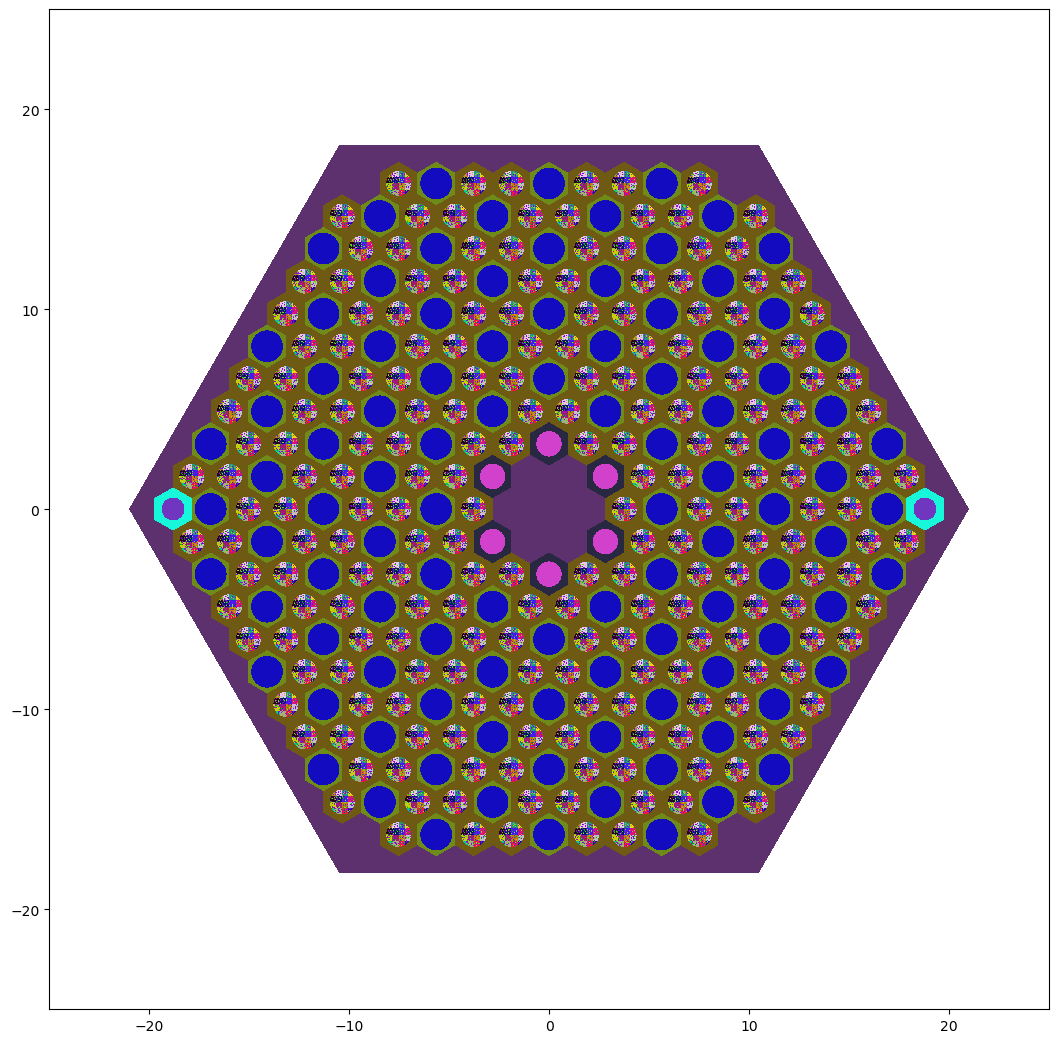

In [11]:
assembly_universe.plot(width=(50, 50), pixels = (1000, 1000), color_by='cell')

In [12]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()



In [13]:
# OpenMC simulation parameters

batches = 10
inactive = 5
particles = 1500


In [14]:
##############################################################################
#                   Exporting to OpenMC settings.xml file
##############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML

settings_file = openmc.Settings()
settings_file.temperature = {
		 'method'    :'interpolation',
		 'tolerance' : 300.0
}
# settings_file.temperature = {'method':'interpolation'}
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)


settings_file.export_to_xml()

In [15]:
# # Create equal-lethargy energies to put in filter

# energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
# e_filter = openmc.EnergyFilter(energies)

# # Create tally with energy filter
# tally = openmc.Tally()
# tally.filters = [e_filter]
# tally.scores = ['flux']
# tallies = openmc.Tallies()
# tallies.append(tally, merge=True)
# tallies.export_to_xml()

In [16]:
# openmc.run()

In [17]:
import math
import openmc.deplete



fuel.volume = 4/3 * 3.1416 * 0.02125**3 * len(triso_particles) * 210


chain = openmc.deplete.Chain.from_xml("/home/razu/Downloads/chain_casl_pwr.xml")


model = openmc.Model(geometry=geom, settings=settings_file)
operator = openmc.deplete.CoupledOperator(model, "/home/razu/Downloads/chain_casl_pwr.xml")



power = (350000000/66)/10

In [18]:

time_steps = [30] * 20

integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')




In [19]:


integrator.integrate()



                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading In113 from /home/razu/Downloads/lib80x/lib80x_hdf5/In113.h5
 Reading In115 from /home/razu/Downloads/lib80x/lib80x_hdf5/In115.h5
 Reading Sb121 from /home/razu/Downloads/lib80x/lib80x_hdf5/Sb121.h5
 Reading Sb123 from /home/razu/Downloads/lib80x/lib80x_hdf5/Sb123.h5
 Reading Sb125 from /home/razu/Downloads/lib80x/lib80x_hdf5/Sb125.h5
 Reading Te127_m1 from /home/razu/Downloads/lib80x/lib80x_hdf5/Te127_m1.h5
 Reading Te129_m1 from /home/razu/Downloads/lib80x/lib80x_hdf5/Te129_m1.h5
 Reading Te132 from /home/razu/Downloads/lib80x/lib80x_hdf5/Te132.h5
 Reading I127 from /home/razu/Downloads/lib80x/lib80x_hdf5/I127.h5
 Reading I128 from /home/razu/Downloads/lib80x/lib80x_hdf5/I128.h5
 Reading I129 from /home/razu/Downloads/lib80x/lib80x_hdf5/I129.h5
 Reading I130 from /home/razu/Downloads/lib80x/lib80x_hdf5/I130.h5
 Reading I131 from /home/razu/Downloads/lib80x/lib80x_hdf5/I131.h5
 Reading I132 from /home/razu/Downloads/lib80x/lib80x_hdf5/I132.h5
 Reading I135 from /home/razu/Down

 Reading Np238 from /home/razu/Downloads/lib80x/lib80x_hdf5/Np238.h5
 Reading Np239 from /home/razu/Downloads/lib80x/lib80x_hdf5/Np239.h5
 Reading Pu236 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu236.h5
 Reading Pu237 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu237.h5
 Reading Pu238 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu238.h5
 Reading Pu239 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu239.h5
 Reading Pu240 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu240.h5
 Reading Pu241 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu241.h5
 Reading Pu242 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu242.h5
 Reading Pu243 from /home/razu/Downloads/lib80x/lib80x_hdf5/Pu243.h5
 Reading Am241 from /home/razu/Downloads/lib80x/lib80x_hdf5/Am241.h5
 Reading Am242 from /home/razu/Downloads/lib80x/lib80x_hdf5/Am242.h5
 Reading Am242_m1 from /home/razu/Downloads/lib80x/lib80x_hdf5/Am242_m1.h5
 Reading Am243 from /home/razu/Downloads/lib80x/lib80x_hdf5/Am243.h5
 Reading Am244 from /home/ra

[openmc.deplete] t=10368000.0 s, dt=2592000 s, source=530303.0303030303
 Maximum neutron transport energy: 20000000 eV for C13
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.08619
        2/1    1.09652
        3/1    1.10028
        4/1    1.05890
        5/1    1.04349
        6/1    1.05876
        7/1    1.08934    1.07405 +/- 0.01529
        8/1    1.13633    1.09481 +/- 0.02256
        9/1    1.15963    1.11101 +/- 0.02274
       10/1    1.12070    1.11295 +/- 0.01772
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.7068e+02 seconds
   Time in transport only          = 2.7067e+02 seconds
   Time

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.03293
        2/1    1.06196
        3/1    1.08203
        4/1    1.04267
        5/1    1.07571
        6/1    0.99887
        7/1    1.07362    1.03624 +/- 0.03738
        8/1    1.10591    1.05947 +/- 0.03170
        9/1    1.06656    1.06124 +/- 0.02249
       10/1    1.01249    1.05149 +/- 0.01996
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.6851e+02 seconds
   Time in transport only          = 2.6849e+02 seconds
   Time in inactive batches        = 1.3351e+02 seconds
   Time in active batches          = 1.3499e+02 seconds
   Time synchronizing fission bank = 9.0500e-04 seconds
     Sampling source sites         = 7.2292e-04 seconds
     SEND/RECV source s

        5/1    1.00017
        6/1    1.04689
        7/1    0.98144    1.01416 +/- 0.03272
        8/1    1.01667    1.01500 +/- 0.01891
        9/1    0.99840    1.01085 +/- 0.01400
       10/1    1.00240    1.00916 +/- 0.01098
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.7511e+02 seconds
   Time in transport only          = 2.7511e+02 seconds
   Time in inactive batches        = 1.3791e+02 seconds
   Time in active batches          = 1.3720e+02 seconds
   Time synchronizing fission bank = 8.6449e-04 seconds
     Sampling source sites         = 6.9254e-04 seconds
     SEND/RECV source sites        = 1.3123e-04 seconds
   Time accumulating tallies       = 1.0346e-03 seconds
   Time writing statepoints        = 2.6320e-03 seconds
 Total time for finalization     

       10/1    1.00512    0.98809 +/- 0.01559
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.7235e+02 seconds
   Time in transport only          = 2.7234e+02 seconds
   Time in inactive batches        = 1.3604e+02 seconds
   Time in active batches          = 1.3631e+02 seconds
   Time synchronizing fission bank = 8.5416e-04 seconds
     Sampling source sites         = 6.9052e-04 seconds
     SEND/RECV source sites        = 1.2327e-04 seconds
   Time accumulating tallies       = 1.8144e-03 seconds
   Time writing statepoints        = 2.5002e-03 seconds
 Total time for finalization       = 6.9073e-05 seconds
 Total time elapsed                = 2.7368e+02 seconds
 Calculation Rate (inactive)       = 55.1301 particles/second
 Calculation Rate (active)         = 55.023

In [20]:
!ls *.h5

depletion_results.h5	  openmc_simulation_n16.h5  openmc_simulation_n4.h5
openmc_simulation_n0.h5   openmc_simulation_n17.h5  openmc_simulation_n5.h5
openmc_simulation_n10.h5  openmc_simulation_n18.h5  openmc_simulation_n6.h5
openmc_simulation_n11.h5  openmc_simulation_n19.h5  openmc_simulation_n7.h5
openmc_simulation_n12.h5  openmc_simulation_n1.h5   openmc_simulation_n8.h5
openmc_simulation_n13.h5  openmc_simulation_n20.h5  openmc_simulation_n9.h5
openmc_simulation_n14.h5  openmc_simulation_n2.h5   statepoint.10.h5
openmc_simulation_n15.h5  openmc_simulation_n3.h5   summary.h5


In [21]:
results = openmc.deplete.Results("./depletion_results.h5")



time, k = results.get_keff()



time /= (24 * 60 * 60)  # convert back to days from seconds




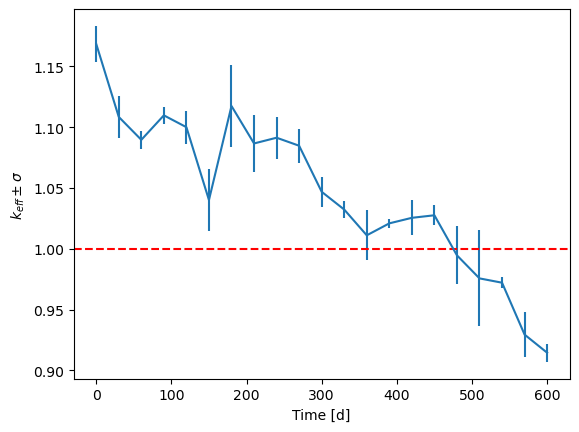

In [22]:

from matplotlib import pyplot



pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

pyplot.axhline(y = 1, color = 'r', linestyle = '--')

In [23]:
k

array([[1.16853098, 0.01480995],
       [1.10848548, 0.01710029],
       [1.08963116, 0.00736711],
       [1.10977071, 0.00719034],
       [1.10003487, 0.01342765],
       [1.04012335, 0.02554783],
       [1.11745518, 0.03394208],
       [1.08665176, 0.02343624],
       [1.09136865, 0.01710164],
       [1.08477252, 0.01417142],
       [1.04689427, 0.01243375],
       [1.03226196, 0.00726575],
       [1.01107992, 0.02042745],
       [1.02091764, 0.00385947],
       [1.02546836, 0.01452336],
       [1.02756722, 0.00804393],
       [0.99461304, 0.02392871],
       [0.97564265, 0.03950531],
       [0.97209506, 0.00452458],
       [0.9294059 , 0.0181864 ],
       [0.91449502, 0.00757057]])

In [32]:


_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_, Sm149 = results.get_atoms("1", "Sm149")
_, pu239 = results.get_atoms("1", "Pu239")



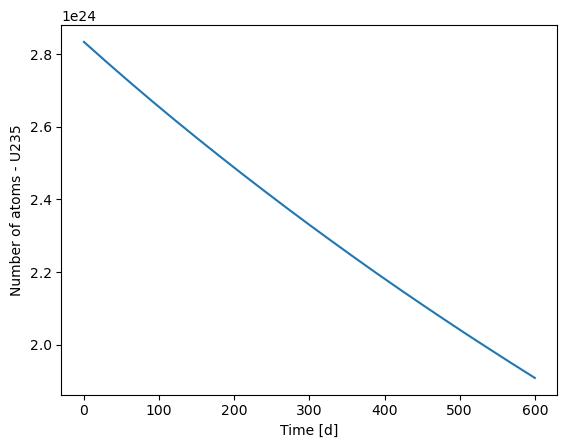

In [25]:


pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");



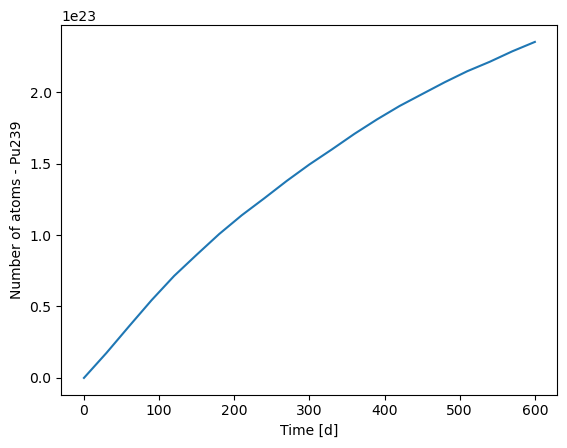

In [26]:
pyplot.plot(time, pu239, label="Pu239")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

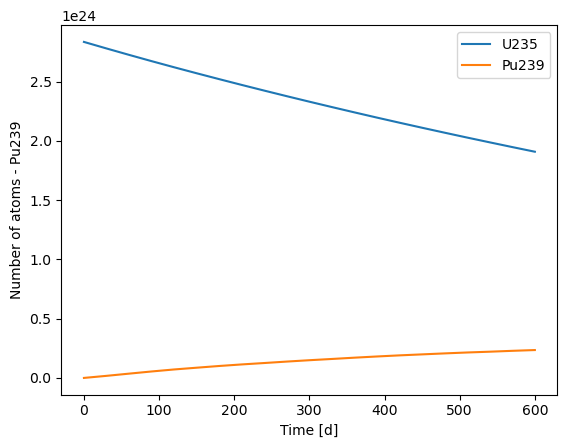

In [27]:

pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");

pyplot.plot(time, pu239, label="Pu239")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.legend()

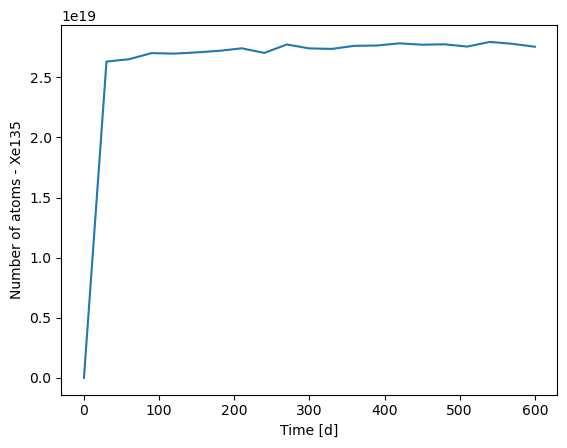

In [28]:


pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");



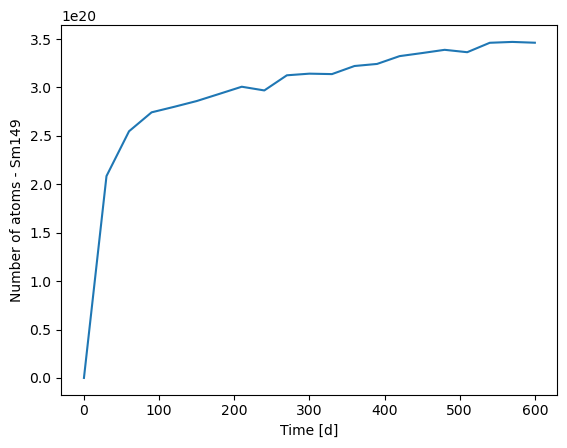

In [33]:
pyplot.plot(time, Sm149, label="Sm149")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Sm149");

In [30]:

_, b4c = results.get_atoms("8", "B10")
pyplot.plot(time, b4c, label="B10")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - B-10");



_, b4c = results.get_atoms("8", "B11")
pyplot.plot(time, b4c, label="B11")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - B-11");

KeyError: '8'

In [ ]:


_, u235_fission = results.get_reaction_rate("1", "U235", "fission")



In [ ]:
pyplot.plot(time, u235_fission)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");